In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from utils import important_channels
import utils
from sklearn.linear_model import LinearRegression

In [2]:
raw_data = pd.read_csv('data/train/Data_S06_Sess04.csv')
feedback_times = raw_data[raw_data['FeedBackEvent'] == 1]['Time']
feedback_indices = feedback_times.index
fs = 200 # sampling frequency
default_channel = important_channels[0] # channel Cz

In [3]:
print(f'Feedback Times: \n{feedback_times}')
print(f'Feedback Indices: \n{feedback_indices}')
print(f'Column names: \n{raw_data.columns}')

Feedback Times: 
4214       21.070
5908       29.540
7591       37.955
9268       46.340
10951      54.755
14155      70.775
16388      81.940
18628      93.140
20845     104.225
23085     115.425
25718     128.590
27398     136.990
29078     145.390
30748     153.740
32415     162.075
35612     178.060
37849     189.245
40072     200.360
42312     211.560
44555     222.775
47216     236.080
48889     244.445
50566     252.830
52252     261.260
53936     269.680
56576     282.880
58262     291.310
59956     299.780
61639     308.195
63319     316.595
66536     332.680
68776     343.880
71013     355.065
73253     366.265
75470     377.350
78680     393.400
80940     404.700
83200     416.000
85437     427.185
87680     438.400
90320     451.600
91997     459.985
93680     468.400
95360     476.800
97033     485.165
99677     498.385
101357    506.785
103030    515.150
104720    523.600
106397    531.985
109577    547.885
111817    559.085
114041    570.205
116281    581.405
118524    5

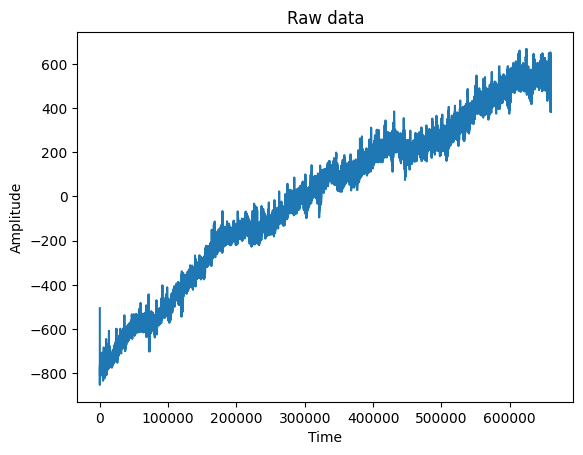

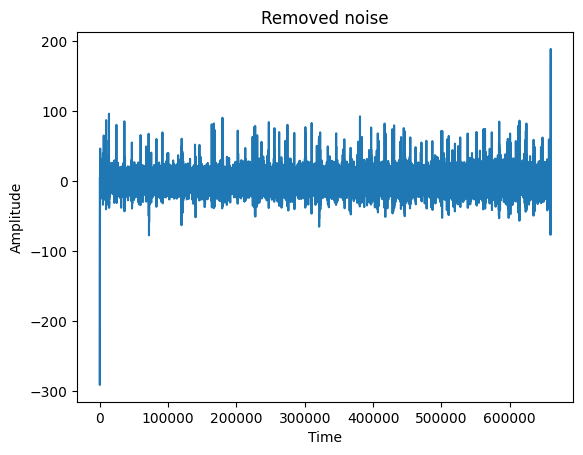

0           4.134743
1        -147.097582
2        -252.151006
3        -291.475411
4        -279.178114
             ...    
131996    179.430472
131997    188.828239
131998    166.250792
131999    106.073112
132000     20.437486
Name: Cz, Length: 132001, dtype: float64


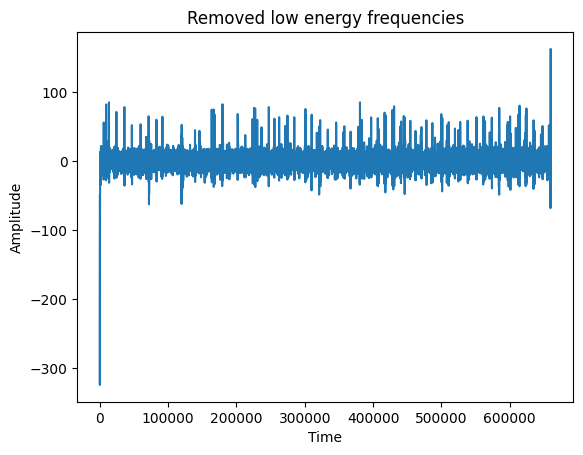

In [3]:
utils.plot_channel(raw_data, 0, default_channel, title='Raw data')

temp = utils.bandpass_filter_all(raw_data, highcut=30)
utils.plot_channel(temp, 0, default_channel, title='Removed noise')
print(temp[default_channel])
filtered_data = utils.bandpass_filter_all(temp, lowcut=0.2, highcut=10)
utils.plot_channel(filtered_data, 0, default_channel, title='Removed low energy frequencies')

In [21]:
proc_channels = filtered_data[important_channels]
print(proc_channels.shape)
data_arr = proc_channels.to_numpy().T
print(f'Data numpy array size: \t{data_arr.shape}')
eog_data = filtered_data['EOG'].to_numpy()
print(f'EOG array size: \t{eog_data.shape}')
eog_data = utils.bandpass_filter_arr(eog_data, highcut=30)

def remove_eog_artifacts(eeg_data, eog_signal):
    eeg_cleaned = np.zeros_like(eeg_data)
    for i in range(eeg_data.shape[0]):
        reg = LinearRegression().fit(eog_signal.reshape(-1, 1), eeg_data[i, :])
        predicted_artifact = reg.predict(eog_signal.reshape(-1, 1))
        eeg_cleaned[i, :] = eeg_data[i, :] - predicted_artifact
    return eeg_cleaned

eeg_cleaned = remove_eog_artifacts(data_arr, eog_data)
print(f'EEG cleaned size: \t{eeg_cleaned.shape}')

(132001, 16)
Data numpy array size: 	(16, 132001)
EOG array size: 	(132001,)
EEG cleaned size: 	(16, 132001)


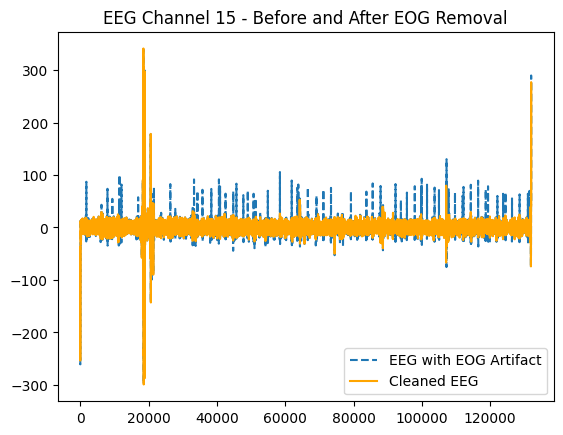

In [27]:
channel = 15
plt.plot(filtered_data[important_channels[channel]], label="EEG with EOG Artifact", linestyle="dashed")
plt.title(f"EEG Channel {channel} - Before and After EOG Removal")
plt.plot(eeg_cleaned[channel], label="Cleaned EEG", color="orange")
plt.legend()
plt.show()

In [63]:
def get_arr_after_feedback(eeg_cleaned, feedback_id=0, before=0.2, after=1.3, fs=200):
    t_index = feedback_indices[feedback_id]
    t = raw_data['Time'][t_index]
    start_idx = int((t - before) * fs)
    end_idx = int((t + after) * fs) + 1
    time = raw_data['Time'][start_idx:end_idx]
    print(f'Feedback index:\t{t_index}')
    print(f'Start index: \t{start_idx}')
    print(f'End index: \t{end_idx}')
    print(f'Length: \t{len(time.to_numpy())}')
    return eeg_cleaned[:, start_idx:end_idx], (time.to_numpy() - t) * 1000

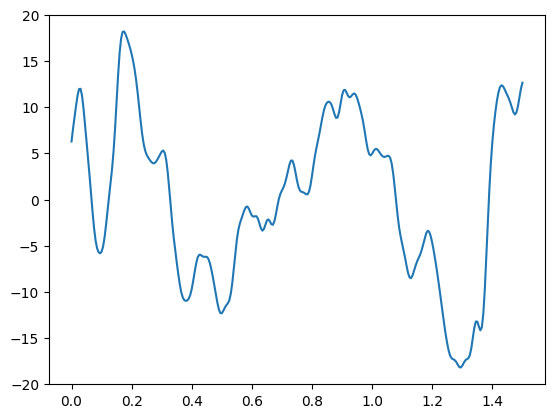

Feedback index:	66536
Start index: 	66496
End index: 	66797
Length: 	301


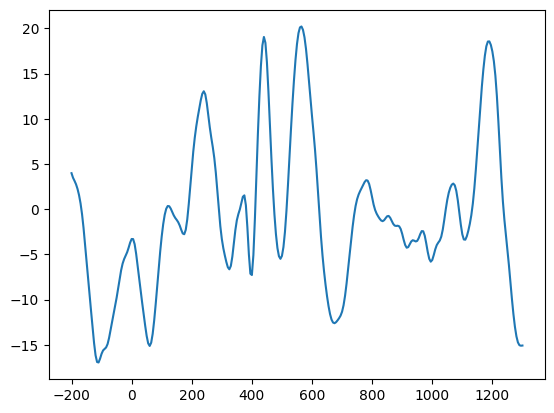

In [66]:
# also check a random part of the data
start_idx = 60000
end_idx = 60301
plt.plot(raw_data['Time'][start_idx:end_idx].to_numpy() - (start_idx/fs), eeg_cleaned[0, start_idx:end_idx])
plt.show()

eeg_part, time = get_arr_after_feedback(eeg_cleaned, feedback_id=30)
plt.plot(time, eeg_part[0])
plt.show()

301


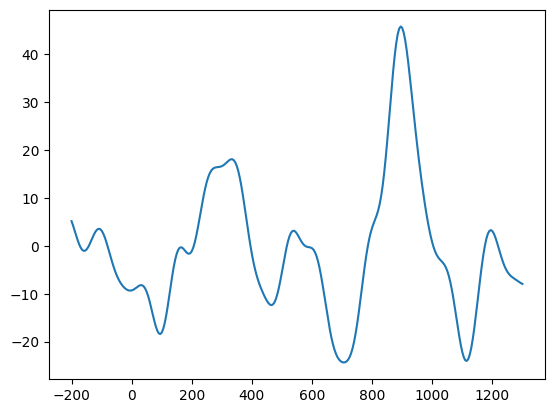

In [16]:
feedback_id = 30
part, t = utils.get_part_after_feedback(filtered_data, feedback_times, feedback_id=feedback_id, before=0.2, after=1.3)
time = (part['Time'] - t) * 1000
print(len(time))
'''for i in range(len(important_channels)):
    plt.plot(time, part[important_channels[i]])
'''
plt.plot(time, part[default_channel])
plt.show()

[ 3.54536568 18.06083361] 45.775746206933746
Latency: 0.895s


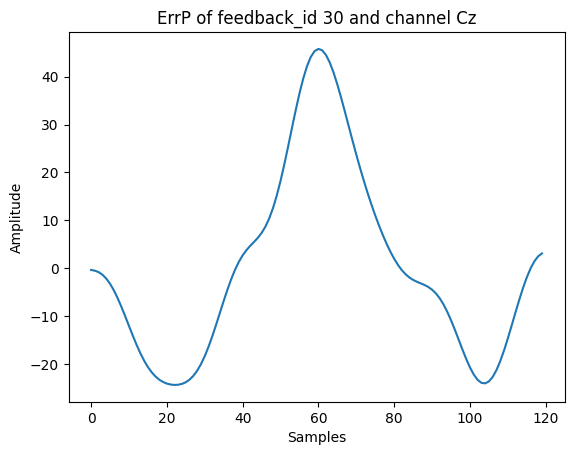

In [17]:
# The criterion is stricter when n is lower and threshold higher
# 'n' is the maximum number of peaks that can be higher than the threshold
# 'threshold' is the ratio of the peak value to the max peak value
# 'lat_fix' should be equal to 'before' parameter of get_part_after_feedback function
def find_errp(np_signal, n=5, threshold=0.5, verbose=False, before=0.3, after=0.3, fs=200, lat_fix=0.2):
    peaks, _ = find_peaks(np_signal)
    peak_values = np_signal[peaks]
    peak_values = peak_values[peak_values > 0]

    max_peak = np.max(peak_values)
    peak_values = peak_values[peak_values != max_peak] # remove the max peak
    peak_values.sort() # sort peaks in ascending order
    peak_values = peak_values[-n:]
    if verbose: print(peak_values, max_peak)
    
    times = 0
    for v in peak_values:
        if (v / max_peak) >= threshold:
            times += 1

    peak_index = np.argmax(np_signal)
    T = 1/fs
    before_samples = int(before/T)
    after_samples = int(after/T) 

    latency = peak_index * T - lat_fix
    if verbose: print(f'Latency: {latency}s')

    return times < n, np_signal[peak_index - before_samples:peak_index + after_samples], latency

check, errp, _ = find_errp(part[default_channel].to_numpy(), n=2, threshold=0.7, verbose=True)
if check: utils.plot_signal(errp, title=f'ErrP of feedback_id {feedback_id} and channel {default_channel}')

In [18]:
N = len(feedback_times)

def calc_accuracy(n, threshold, verbose=True):
    counter = 0
    for i in range(N):
        part, _ = utils.get_part_after_feedback(filtered_data, feedback_times, feedback_id=i, before=0.2, after=1.3)
        check, _, _ = find_errp(part[default_channel].to_numpy(), n=2, threshold=0.7)
        if check: counter += 1
    accuracy = counter/N
    if verbose: print(f'Accuracy: {accuracy*100}% ({counter}/{N})')
    return accuracy

calc_accuracy(2, 0.7)

Accuracy: 83.33333333333334% (50/60)


0.8333333333333334

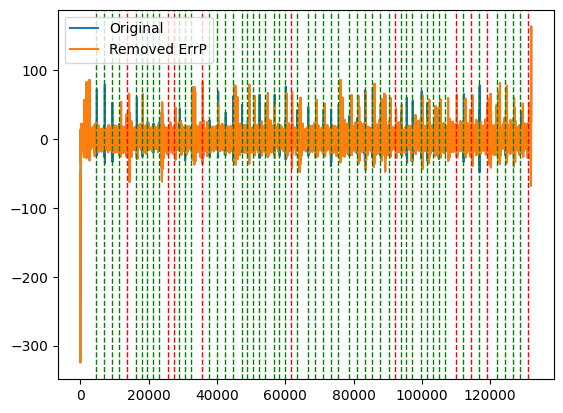

In [19]:
removed_errp = filtered_data.copy()
errp_indices = []
for i in range(N):
    part, t = utils.get_part_after_feedback(filtered_data, feedback_times, feedback_id=i, before=0.2, after=1.3)
    check, errp, lat = find_errp(part[default_channel].to_numpy(), n=2, threshold=0.7)
    if check:
        #print(t, int(t*fs))
        removed_errp.loc[int(t*fs):int(t*fs)+len(part), default_channel] = 0
        errp_indices.append(i)

plt.plot(filtered_data[default_channel])
plt.plot(removed_errp[default_channel])
#plt.plot(eeg_cleaned[0], color='gray')
counter = 0
c = 'r'
for x_line in feedback_indices:
    if counter in errp_indices:
        c = 'g'
    else:
        c = 'r'
    plt.axvline(x=x_line, color=c, linestyle='--', linewidth=1, label=f"x={x_line}" if x_line == feedback_indices[0] else "")
    counter += 1

plt.legend(['Original', 'Removed ErrP'])#, 'Cleaned EEG'])
plt.show()

In [30]:
print(f'There are {len(feedback_times)} feedback times')
for i in range(len(feedback_indices)):
    if i == 0:
        print(f'[word {int(i/5)}, letter {i%5}] {feedback_times.iloc[i]}')
    else:
        print(f'[word {int(i/5)}, letter {i%5}] {feedback_times.iloc[i] - feedback_times.iloc[i-1]}')


There are 60 feedback times
[word 0, letter 0] 23.54
[word 0, letter 1] 11.204999999999998
[word 0, letter 2] 11.215000000000003
[word 0, letter 3] 11.185000000000002
[word 0, letter 4] 11.214999999999996
[word 1, letter 0] 13.165000000000006
[word 1, letter 1] 8.384999999999991
[word 1, letter 2] 8.420000000000002
[word 1, letter 3] 8.400000000000006
[word 1, letter 4] 8.379999999999995
[word 2, letter 0] 13.135000000000005
[word 2, letter 1] 8.414999999999992
[word 2, letter 2] 8.384999999999991
[word 2, letter 3] 8.38500000000002
[word 2, letter 4] 8.414999999999992
[word 3, letter 0] 15.969999999999999
[word 3, letter 1] 11.314999999999998
[word 3, letter 2] 11.215000000000003
[word 3, letter 3] 11.185000000000002
[word 3, letter 4] 11.300000000000011
[word 4, letter 0] 13.234999999999985
[word 4, letter 1] 8.485000000000014
[word 4, letter 2] 8.399999999999977
[word 4, letter 3] 8.53000000000003
[word 4, letter 4] 8.449999999999989
[word 5, letter 0] 13.21999999999997
[word 5, let

In [18]:
def is_last_letter(feedback_id):
    return feedback_id % 5 == 4

def get_break_after_feedback(feedback_id, channel = default_channel):
    break_time = 4.5 if is_last_letter(feedback_id) else 0.5
    
    t1 = feedback_times.iloc[feedback_id] + 1.3 # end of feedback
    t2 = t1 + break_time
    part = filtered_data[channel].to_numpy()
    part = part[int(t1*fs):int(t2*fs)+1]
    part_mean = np.mean(part)

    return break_time, part_mean

In [26]:
print(feedback_indices.size)
id = 10
test_idx = feedback_indices[id]
test_time = feedback_times.iloc[id]
print(f'Feedback index: {test_idx} vs {int(test_time*fs)}')

60
Feedback index: 25649 vs 25649


In [52]:
def get_erp_segment(feedback_id, channel = default_channel):
    break_time, _ = get_break_after_feedback(feedback_id, channel)
    
    t1 = feedback_times.iloc[feedback_id] + 1.3 + break_time
    if feedback_id < feedback_indices.size - 1:
        t2 = feedback_times.iloc[feedback_id + 1]
    else:
        t2 = filtered_data['Time'].iloc[-1]
    part = filtered_data[channel].to_numpy()
    part = part[int(t1*fs):int(t2*fs)+1]

    return part
    
def get_blinking_time(feedback_id, channel = default_channel):
    part = get_erp_segment(feedback_id, channel)
    dt = len(part) / fs - 2
    if dt <= 6.64:
        return 2.64
    elif dt > 6.64 and dt < 7.78:
        d1 = abs(6.64 - dt)
        d2 = abs(7.78 - dt)
        return 2.64 if d1 < d2 else 5.28
    else:
        return 5.28

extra_offset = 0.1
def get_important_parts(feedback_id, channel = default_channel):
    erp_segment = get_erp_segment(feedback_id, channel)
    data = {}
    data['feedback_id'] = feedback_id
    data['channel'] = channel

    # find the green circle part
    green_end = 1
    data['green_raw'] = erp_segment[:int((green_end+extra_offset)*fs)]
    _, break_mean = get_break_after_feedback(feedback_id, channel)
    data['green_processed'] = data['green_raw'] - break_mean

    # find the between break part mean to process the blinking part
    between_break_end = 2
    between_break = erp_segment[int(green_end*fs):int(between_break_end*fs)]
    between_break_mean = np.mean(between_break)

    # find the blinking part
    blinking_time = get_blinking_time(feedback_id, channel)
    blinking_start = between_break_end - extra_offset
    blinking_end = blinking_start + blinking_time + extra_offset
    data['blinking_raw'] = erp_segment[int(blinking_start*fs):int(blinking_end*fs)]
    data['blinking_processed'] = data['blinking_raw'] - between_break_mean

    return data

def sliding_window(feedback_id, channel = default_channel):
    data = get_important_parts(feedback_id, channel)
    blinking_data = data['blinking_processed']
    
    window_time = 0.5
    window_size = int(window_time * fs)
    window_step = int(0.25 * fs)
    windows = []
    num_windows = (len(blinking_data) - window_size) // window_step + 1
    
    for i in range(num_windows):
        window = {}
        window['signal'] = blinking_data[i*window_step:i*window_step+window_size]
        window['mean'] = np.mean(window['signal'])
        window['peak'] = np.max(window['signal'])
        window['latency'] = np.argmax(window['signal']) / fs
        window['amplitude'] = np.max(window['signal']) - np.min(window['signal'])
        windows.append(window)
          
    # not a sliding window but add the green circle part as a window
    green_data = data['green_processed']
    green_window = {
        'signal': green_data,
        'mean': np.mean(green_data),
        'peak': np.max(green_data),
        'latency': np.argmax(green_data) / fs,
        'amplitude': np.max(green_data) - np.min(green_data)
    }
    windows.append(green_window)

    return windows

In [53]:
def extract_features(feedback_id, verbose=False):
    feature_matrix = []
    for channel in important_channels:
        windows = sliding_window(feedback_id, channel)
        channel_mean = []            
        channel_peak = []
        channel_latency = []
        channel_amplitude = []

        for w in windows:
            channel_mean.append(w['mean'])
            channel_peak.append(w['peak'])
            channel_latency.append(w['latency'])
            channel_amplitude.append(w['amplitude'])
        feature_matrix.append(channel_mean)
        feature_matrix.append(channel_peak)
        feature_matrix.append(channel_latency)
        feature_matrix.append(channel_amplitude)

        if verbose: print(f'Channel {channel} with {len(windows)} windows')

    return np.array(feature_matrix).T

In [54]:
features = []
for id in range(feedback_indices.size-1):
    temp = extract_features(id)
    print(f'shape for id {id} is {temp.shape}')
    features.append(temp)

features = np.vstack(features)
print(f'Final shape: {features.shape}')

shape for id 0 is (21, 64)
shape for id 1 is (21, 64)
shape for id 2 is (21, 64)
shape for id 3 is (21, 64)
shape for id 4 is (10, 64)
shape for id 5 is (10, 64)
shape for id 6 is (10, 64)
shape for id 7 is (10, 64)
shape for id 8 is (10, 64)
shape for id 9 is (10, 64)
shape for id 10 is (10, 64)
shape for id 11 is (10, 64)
shape for id 12 is (10, 64)
shape for id 13 is (10, 64)
shape for id 14 is (21, 64)
shape for id 15 is (21, 64)
shape for id 16 is (21, 64)
shape for id 17 is (21, 64)
shape for id 18 is (21, 64)
shape for id 19 is (10, 64)
shape for id 20 is (10, 64)
shape for id 21 is (10, 64)
shape for id 22 is (10, 64)
shape for id 23 is (10, 64)
shape for id 24 is (10, 64)
shape for id 25 is (10, 64)
shape for id 26 is (10, 64)
shape for id 27 is (10, 64)
shape for id 28 is (10, 64)
shape for id 29 is (21, 64)
shape for id 30 is (21, 64)
shape for id 31 is (21, 64)
shape for id 32 is (21, 64)
shape for id 33 is (21, 64)
shape for id 34 is (21, 64)
shape for id 35 is (21, 64)
sh

Green time: 1.1s
Blinking time: 5.375s


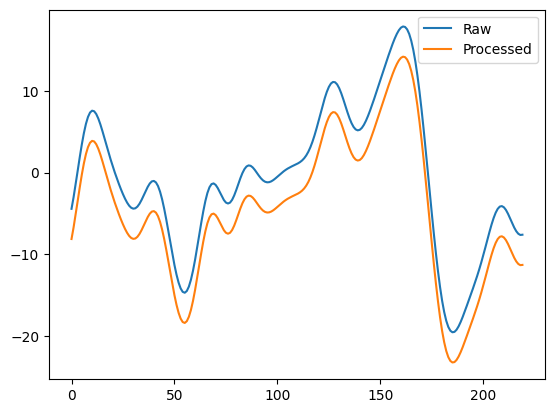

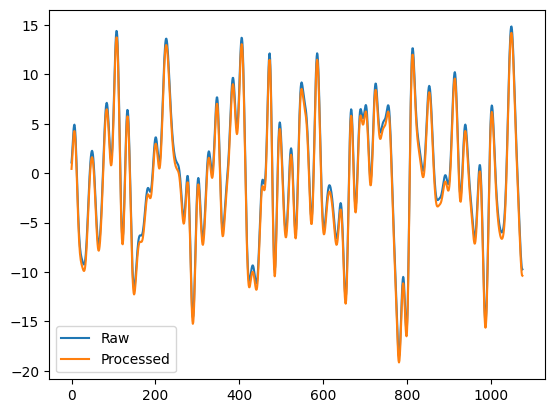

In [34]:
data = get_important_parts(0)
print(f'Green time: {len(data["green_raw"])/fs}s')
print(f'Blinking time: {len(data["blinking_raw"])/fs}s')

plt.plot(data['green_raw'], label='Raw')
plt.plot(data['green_processed'], label='Processed')
plt.legend()
plt.show()

plt.plot(data['blinking_raw'], label='Raw')
plt.plot(data['blinking_processed'], label='Processed')
plt.legend()
plt.show()

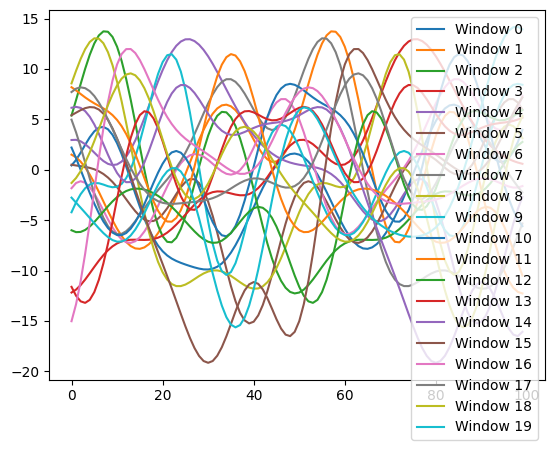

In [36]:
windows = sliding_window(0)
for i in range(len(windows)):
    plt.plot(windows[i]['signal'], label=f'Window {i}')
plt.legend()
plt.show()

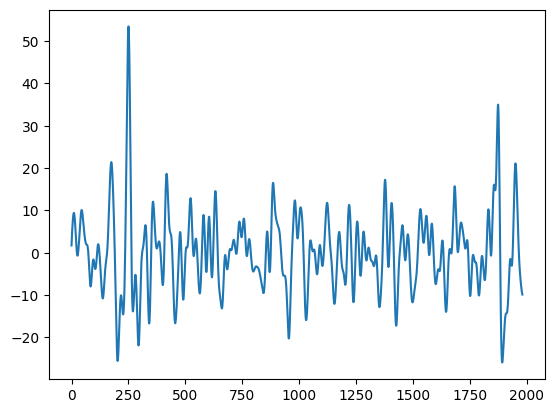

In [20]:
offset = 3
t1 = feedback_times.iloc[offset] + 1.3
t2 = feedback_times.iloc[offset+1]
signal = filtered_data[default_channel].to_numpy()
signal = signal[int(t1*fs):int(t2*fs)]
plt.plot(signal)
plt.show()

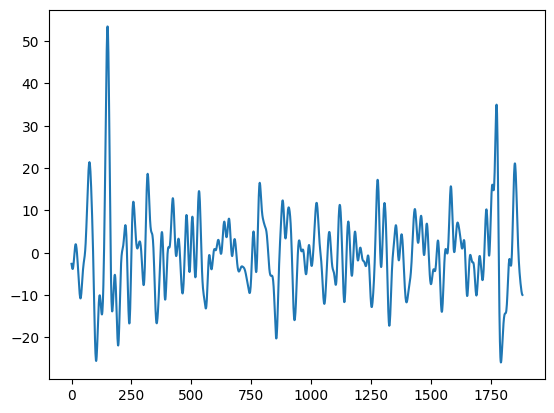

Part duration: 9.42s


In [21]:
part = get_erp_segment(offset)
plt.plot(part)
plt.show()

length = len(part)
print(f'Part duration: {length/fs}s')

In [28]:
for i in range(feedback_times.size-1):
    part = get_erp_segment(i)
    break_time = get_break_after_feedback(i)[0]
    print(f'Part {i} duration: {len(part)/fs}s\t{len(part)/fs-2}\t{break_time}')

Part 0 duration: 9.405s	7.404999999999999	0.5
Part 1 duration: 9.425s	7.425000000000001	0.5
Part 2 duration: 9.39s	7.390000000000001	0.5
Part 3 duration: 9.42s	7.42	0.5
Part 4 duration: 7.37s	5.37	4.5
Part 5 duration: 6.59s	4.59	0.5
Part 6 duration: 6.625s	4.625	0.5
Part 7 duration: 6.605s	4.605	0.5
Part 8 duration: 6.585s	4.585	0.5
Part 9 duration: 7.34s	5.34	4.5
Part 10 duration: 6.62s	4.62	0.5
Part 11 duration: 6.585s	4.585	0.5
Part 12 duration: 6.59s	4.59	0.5
Part 13 duration: 6.62s	4.62	0.5
Part 14 duration: 10.175s	8.175	4.5
Part 15 duration: 9.52s	7.52	0.5
Part 16 duration: 9.42s	7.42	0.5
Part 17 duration: 9.39s	7.390000000000001	0.5
Part 18 duration: 9.505s	7.505000000000001	0.5
Part 19 duration: 7.44s	5.44	4.5
Part 20 duration: 6.69s	4.69	0.5
Part 21 duration: 6.605s	4.605	0.5
Part 22 duration: 6.735s	4.735	0.5
Part 23 duration: 6.655s	4.655	0.5
Part 24 duration: 7.42s	5.42	4.5
Part 25 duration: 6.58s	4.58	0.5
Part 26 duration: 6.61s	4.61	0.5
Part 27 duration: 6.6s	4.6	0.5
Par